# Natural Computing - Particle Swarm Optimization
This notebook is used on Kaggle for the Natural Computing project. In this notebook the dataset Metastatic Tissue Classification - PatchCamelyon (metastatic-tissue-classification-patchcamelyon) is used.

# Imports

In [1]:
%%capture
import sys
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import backend as K

import pyswarms
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface

import h5py

# Pretrained model (VGG16)

Setup of the Keras model VGG16 (pretrained weights on ImageNet), all layers are pretrained except the last layer. A Dense layer is added.

In [2]:
def pretrained_model_last(img_shape, num_classes, layer_type, summary_print=False):
  vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

  for layer in vgg16.layers:
    if layer.name == 'block5_conv3':
      break
    layer.trainable = False
  
  last = vgg16.layers[-1].output
  print(vgg16.input.shape)

  x = Flatten(name='flatten')(last)
  x = Dense(num_classes, activation=layer_type, name='predictions')(x)
    
  pretrained_model = Model(inputs=vgg16.input, outputs=x)
  
  layer_last = pretrained_model.layers[-1]

  if summary_print==True:
    pretrained_model.summary()

  return pretrained_model

# Patch Camelyon

Characteristics of the data

In [3]:
num_classes = 2
input_shape = (96,96,3)

## Select part of the data (n samples)

Import the data from the dataset and define the number of samples from the train set to run with the PSO.

In [4]:
num_samples = 1000

x_train_sample = []
y_train_sample = []

x_test = []
y_test = []

with h5py.File('/kaggle/input/metastatic-tissue-classification-patchcamelyon/pcam/training_split.h5', 'r') as f:
    x_train_sample = np.array(f['x'][:num_samples])

with h5py.File('/kaggle/input/metastatic-tissue-classification-patchcamelyon/Labels/Labels/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
    y_train_sample = np.array(f['y'][:num_samples].flat)

with h5py.File('/kaggle/input/metastatic-tissue-classification-patchcamelyon/pcam/test_split.h5', 'r') as f:
    x_test = np.array(f['x'][:])

with h5py.File('/kaggle/input/metastatic-tissue-classification-patchcamelyon/Labels/Labels/camelyonpatch_level_2_split_test_y.h5', 'r') as f:
    y_test = np.array(f['y'][:].flat)

In [5]:
print(x_train_sample.shape)
print(y_train_sample.shape)

(1000, 96, 96, 3)
(1000,)


## Particle Swarm Optimization

In [7]:
model_patch_pso = pretrained_model_last(img_shape=input_shape, num_classes=num_classes, layer_type='softmax', summary_print=True)

58892288/58889256 [==============================] - 2s 0us/step
(None, 96, 96, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
____________________________________________

## Particle Swarm optimization

* Define number of inputs, hidden and classes 
* Calculate the dimensions
* Retrieve the layer to train
* Define input for the PSO
* Apply PSO optimizer 
    * Logits function to update weights and biases of a particle
    * Forward propagation (for one particle)
        * apply softmax and negative log likelihood
    * Compute forward propagation and thus the loss for the whole swarm

In [8]:
n_inputs = 4608
n_hidden = 1 
n_classes = 2 

In [9]:
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
print(dimensions)

4613


In [10]:
layer_flatten = K.function([model_patch_pso.layers[0].output],
                                  [model_patch_pso.layers[-2].output])
flatten_output = layer_flatten([x_train_sample])[0]

In [11]:
X = flatten_output.reshape((num_samples, n_inputs))
y = y_train_sample
print(X.shape)
print(y.shape)

(1000, 4608)
(1000,)


In [12]:
layer_last = model_patch_pso.layers[-1]
weights_ll = np.array(layer_last.get_weights())
print(weights_ll[0].shape)

(4608, 2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Compute the logits (weights and biases)

In [13]:
def logits_function(p):
    start = 0
    end = n_inputs*n_hidden
    W1 = p[start:end].reshape((n_inputs,n_hidden))

    start = end 
    end = start+n_hidden
    b1 = p[start:end].reshape((n_hidden,))

    start = end 
    end = start+(n_classes*n_hidden)
    W2 = p[start:end].reshape((n_hidden,n_classes))

    start = end 
    end = start+n_classes
    b2 = p[start:end].reshape((n_classes,))

    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)     
    logits = a1.dot(W2) + b2 
    return logits     


* Compute the softmax activation for the returned logits, 
* Compute the negative log-likelihood loss and return this.
The negative log-likelihood loss is the error between the predictions and theground truth.

In [21]:
def forward_prop(params):
    logits = logits_function(params)

    # Softmax (logits)
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Negative log likelihood
    corect_logprobs = -np.log(probs[range(num_samples), y])
    loss = np.sum(corect_logprobs) / num_samples

    return loss

The loss for each particle of the swarm is the resultof the forward propagation.

In [15]:
def f(x):
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

Prediction function for the given positions (sum up to 1)

In [16]:
def predict(pos):
    logits = logits_function(pos)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

* Define the intializations for the swarm
* Apply PSO
    * Define the optimzer for the patch data 
    * Optimize the optimizer given the swarm optimizer function defined earlier (f)
* Plot the cost of the optimization
* Accuracy 
* Confusion matrix

The personal best position (given the loss) is compared to the current position for each particlein the swarm.  After this, the personal best is compared to the global best, and the matrices (position andcosts) are updated.  We want the cost as low as possible (close to zero), and the cost represents the lowestvalue of the loss.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Cost:  0.6575986332969449


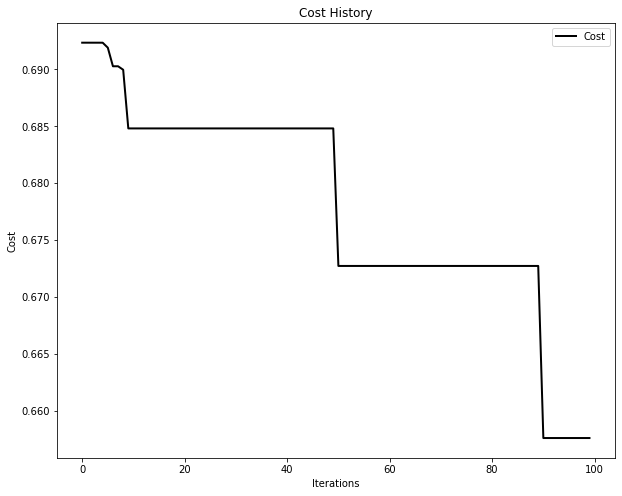

Accuracy:  0.66


In [23]:
options = {'c1': 0.25, 'c2': 3, 'w':0.8} #options in order to initialize swarm

dimensions = dimensions
optimizer_patch_pso = pyswarms.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options) 
cost_patch, pos_patch = optimizer_patch_pso.optimize(f, iters=100, verbose=0) 

print('Cost: ', cost_patch)

plot_cost_history(optimizer_patch_pso.cost_history)
plt.show()

print('Accuracy: ', (predict(pos_patch) == y).mean())

#prediction_pso = predict(pos_patch)
#confusion_matrix(y_test[:num_samples],prediction_pso)